# ASAP Human Postmortem-Derived Brain Sequencing Collection (PMDBS): Gene Expression 

In a [previous notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/asap_pmdbs_data_and_metadata.html), we provided an overview of the ASAP PMDBS dataset and associated cell, sample and donor metadata.  In this notebook we provided example code on how to access gene expression value and plot them on the PMDBS UMAP.

You need to be connected to the internet to run this notebook and should have run through the [getting started notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html).

In [1]:
from typing import List
import time
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path
import numpy as np
import anndata
from scipy.sparse import csr_matrix

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the AbcProjectCache. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the [getting started notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been.

Change the download_base variable to where you have downloaded the data in your system.

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20250331/manifest.json'

## Data Overview

We load the cell and associated metadata and genes. For more details on these data see the previous [Data and Metadta notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/asap_pmdbs_data_and_metadata.html).

In [3]:
cell_metadata = abc_cache.get_metadata_dataframe(
    directory='ASAP-PMDBS-10X',
    file_name='cell_metadata'
).set_index('cell_label')

In [4]:
donor = abc_cache.get_metadata_dataframe(
    directory='ASAP-PMDBS-10X',
    file_name='donor'
).set_index('donor_label')
sample = abc_cache.get_metadata_dataframe(
    directory='ASAP-PMDBS-10X',
    file_name='sample'
).set_index('sample_label')
value_sets = abc_cache.get_metadata_dataframe(
    directory='ASAP-PMDBS-10X',
    file_name='value_sets'
).set_index('label')

In [5]:
cell_metadata = cell_metadata.join(sample, on='sample_label')
cell_metadata = cell_metadata.join(donor, on='donor_label')
cell_metadata.head()

,cell_barcode,sample_label,x,y,cluster_label,cluster_label_order,cluster_label_color,dataset_label,feature_matrix_label,abc_sample_id,...,cerad_score_color,cognitive_status,cognitive_status_order,cognitive_status_color,lewy_body_disease_pathology,lewy_body_disease_pathology_order,lewy_body_disease_pathology_color,thal_phase,thal_phase_order,thal_phase_color
cell_label,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAAACCAT-1_ASAP_PMBDS_000060_s002_Rep1,AAACCCAAGAAACCAT-1,ASAP_PMBDS_000060_s002,0.016373,1.403025,cluster_000,1,#171c97,ASAP-PMDBS-10X,ASAP-PMDBS-10X,cc633260-614c-4e5c-aa18-d3e3a0ef81bb,...,#4daf4a,Unknown,4,#e8e8e8,Absent,1,#ffffd9,Thal 3,4,#df65b0
AAACCCAAGAAACTCA-1_ASAP_PMBDS_000088_s001_Rep1,AAACCCAAGAAACTCA-1,ASAP_PMBDS_000088_s001,10.029368,1.342043,cluster_013,14,#aa5ed0,ASAP-PMDBS-10X,ASAP-PMDBS-10X,4b4f4355-6463-4bf2-9544-3f6d493de741,...,#4daf4a,Unknown,4,#e8e8e8,Absent,1,#ffffd9,Thal 2,3,#c994c7
AAACCCAAGAAAGCGA-1_ASAP_PMBDS_000177_s001_rep1,AAACCCAAGAAAGCGA-1,ASAP_PMBDS_000177_s001,-9.057206,-1.032092,cluster_006,7,#f591a5,ASAP-PMDBS-10X,ASAP-PMDBS-10X,0ea675f3-4b39-4c16-9518-66ddd9c409a1,...,#e41a1c,Mild Cognitive Impairment,2,#377eb8,Brainstem/Limbic,5,#41b6c4,Thal 3,4,#df65b0
AAACCCAAGAAAGCGA-1_ASAP_PMBDS_000185_s001_rep1,AAACCCAAGAAAGCGA-1,ASAP_PMBDS_000185_s001,-0.685645,-4.943793,cluster_001,2,#e4a9ba,ASAP-PMDBS-10X,ASAP-PMDBS-10X,0eb0506b-e76b-4f9a-a3b6-bc6bbccfdd32,...,#e41a1c,Mild Cognitive Impairment,2,#377eb8,Brainstem predominant,4,#7fcdbb,Thal 3,4,#df65b0
AAACCCAAGAAATCCA-1_ASAP_PMBDS_000122_s002_1,AAACCCAAGAAATCCA-1,ASAP_PMBDS_000122_s002,-3.507261,13.855699,cluster_002,3,#a02226,ASAP-PMDBS-10X,ASAP-PMDBS-10X,1f67fc2a-7e81-4448-8437-e2c6ef8b4b1b,...,#e8e8e8,Unknown,4,#e8e8e8,Unknown,10,#e8e8e8,Unknown,8,#e8e8e8


## Single cell transcriptomes

The ~3 million cell dataset contains gene expression data for 36k genes.  

Below we show some interactions with data from the 10X expression matrix. For a deeper dive into how to access specific gene data from the expression matrices, take a look at general_acessing_10x_snRNASeq_tutorial.ipynb. Below we will use precomputed metadata from these matrices to look at gene expression both in relation to different neurotransmitters and locations across the brain. 

First, we load the list of genes available in ASAP data. 

In [6]:
genes = abc_cache.get_metadata_dataframe(
    directory='ASAP-PMDBS-10X',
    file_name='gene'
).set_index('gene_identifier')
genes.head()

gene.csv: 100%|██████████████████████████████████████████████████████████████████████████████| 2.43M/2.43M [00:00<00:00, 4.63MMB/s]


,gene_symbol,molecular_type,description
gene_identifier,,,
ENSG00000243485,MIR1302-2HG,lncRNA,MIR1302-2 host gene
ENSG00000237613,FAM138A,lncRNA,family with sequence similarity 138 member A
ENSG00000186092,OR4F5,protein_coding,olfactory receptor family 4 subfamily F member 5
ENSG00000238009,AL627309.1,lncRNA,novel transcript
ENSG00000239945,AL627309.3,lncRNA,novel transcript


We’ll skip accessing these data from the expression matrices specifically for now, however, users can learn how to access specific genes from the released expression matrices in the [general_acessing_10x_snRNASeq_tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) notebook. 

The precomputed table below contains expressions for the genes SLC17A6, SLC17A7, SLC32A1, PTPRC, PLP1, AQP4, and TTR for all cells across the ASAP dataset. We then join this with our previously created cell_metadata, pandas DataFrame from this tutorial. 

In [7]:
example_cells_with_genes = abc_cache.get_metadata_dataframe(
    directory='ASAP-PMDBS-10X',
    file_name='example_genes_all_cells_expression'
).set_index('cell_label')
example_cells_with_genes.head()

example_genes_all_cells_expression.csv: 100%|██████████████████████████████████████████████████| 236M/236M [00:54<00:00, 4.35MMB/s]


,PTPRC,SLC17A6,AQP4,TTR,SLC17A7,SLC32A1,PLP1
cell_label,,,,,,,
AAACCCAAGAAACCAT-1_ASAP_PMBDS_000060_s002_Rep1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
AAACCCAAGAAACTCA-1_ASAP_PMBDS_000088_s001_Rep1,0.0,0.0,0.0,0.0,5.338431,0.0,0.000000
AAACCCAAGAAAGCGA-1_ASAP_PMBDS_000177_s001_rep1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
AAACCCAAGAAAGCGA-1_ASAP_PMBDS_000185_s001_rep1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
AAACCCAAGAAATCCA-1_ASAP_PMBDS_000122_s002_1,0.0,0.0,0.0,0.0,0.000000,0.0,9.277917


Finally, we'll merge the gene expression into the full cell metadata table.

In [8]:
cell_metadata = cell_metadata.join(example_cells_with_genes)

## Example use cases

In this section, we show a use case with the example genes SLC17A6, SLC17A7, SLC32A1, PTPRC, PLP1, AQP4, and TTR. These genes were selected because they were presented in Siletti et al. 2023 as markers genes for glutamatergic (SLC17A6, SLC17A7) and GABAergic (SLC32A1) neurons, immune cells (PTPRC), oligodendrocytes (PLP1), astrocytes (AQP4), and choroid plexus (TTR) and we duplicate the analysis from our previous tutorial here. “Marker genes” have much higher expression in the specified cell type or anatomic structure when compared to all other cells, and in many cases are functionally relevant for those cell types.  

Below we plot a UMAP colorized by metadata or expression values like what was used in the other ASAP data tutorials. 

In [9]:
def plot_umap(
    xx,
    yy,
    cc=None,
    val=None,
    fig_width=8,
    fig_height=8,
    cmap=None,
    labels=None,
    term_order_lookup=None,
    colorbar=False,
    sizes=None
):
    """
    """
    if sizes is None:
        sizes = 1
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None:
        scatt = ax.scatter(xx, yy, c=val, s=0.5, marker='.', cmap=cmap, alpha=sizes)
    elif cc is not None:
        scatt = ax.scatter(xx, yy, c=cc, s=0.5, marker='.', alpha=sizes)

    if labels is not None:
        from matplotlib.patches import Rectangle
        unique_labels = labels.unique()
        unique_colors = cc.unique()

        if term_order_lookup is not None:
            term_order = np.argsort(term_order_lookup.loc[unique_labels, 'term_order'])
            unique_labels = unique_labels[term_order]
            unique_colors = unique_colors[term_order]
            
        rects = []
        for color in unique_colors:
            rects.append(Rectangle((0, 0), 1, 1, fc=color))

        legend = ax.legend(rects, unique_labels, loc=2)
        # ax.add_artist(legend)

    if colorbar:
        fig.colorbar(scatt, ax=ax)
    
    return fig, ax

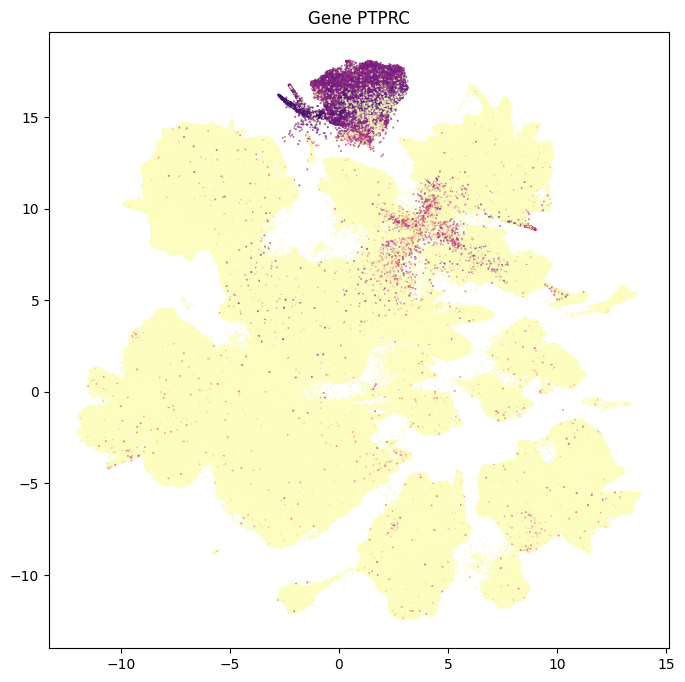

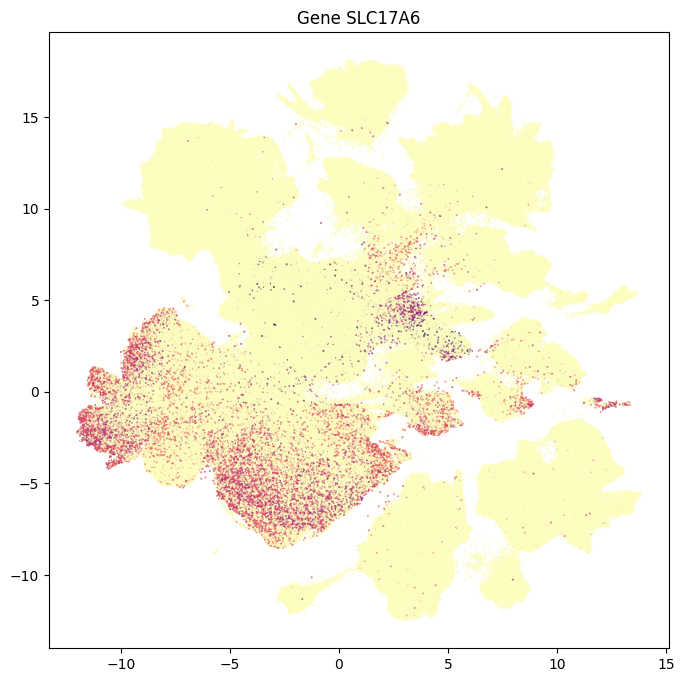

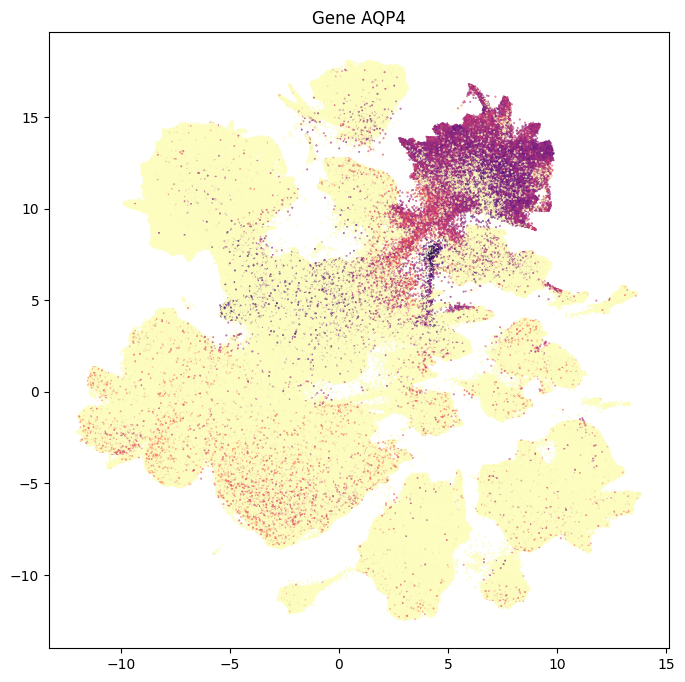

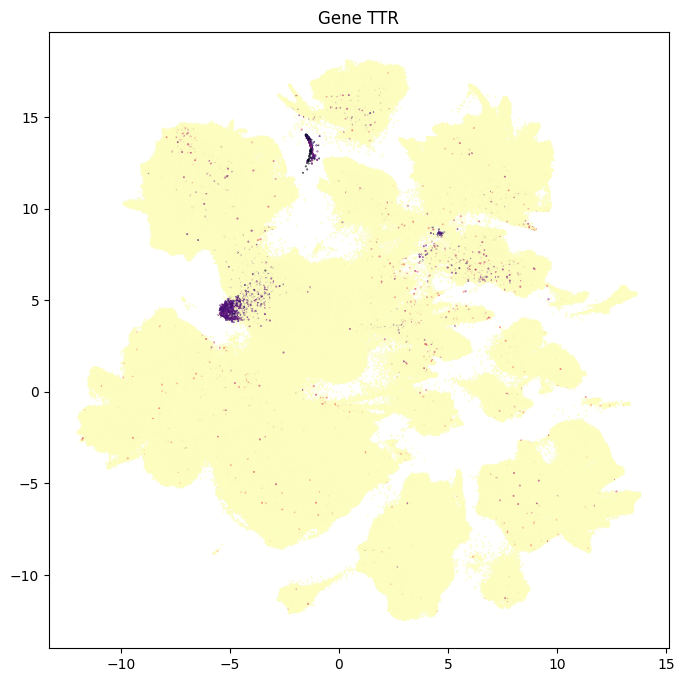

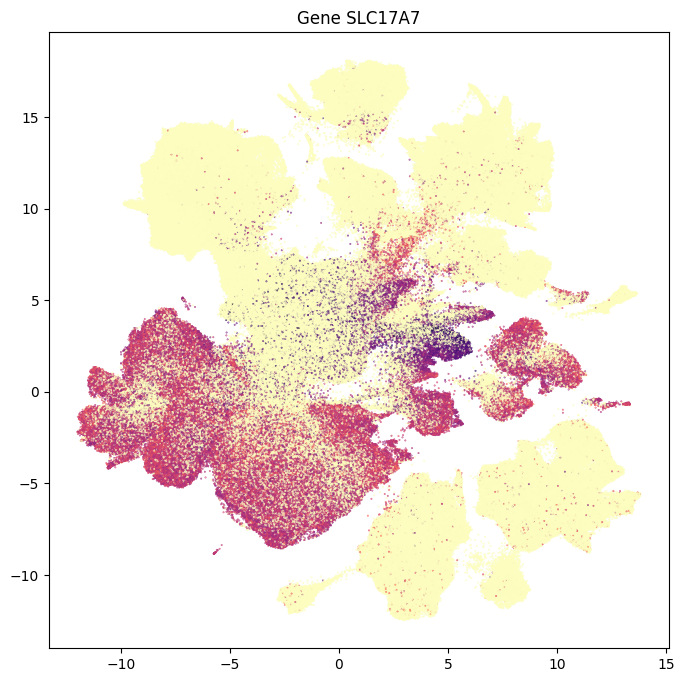

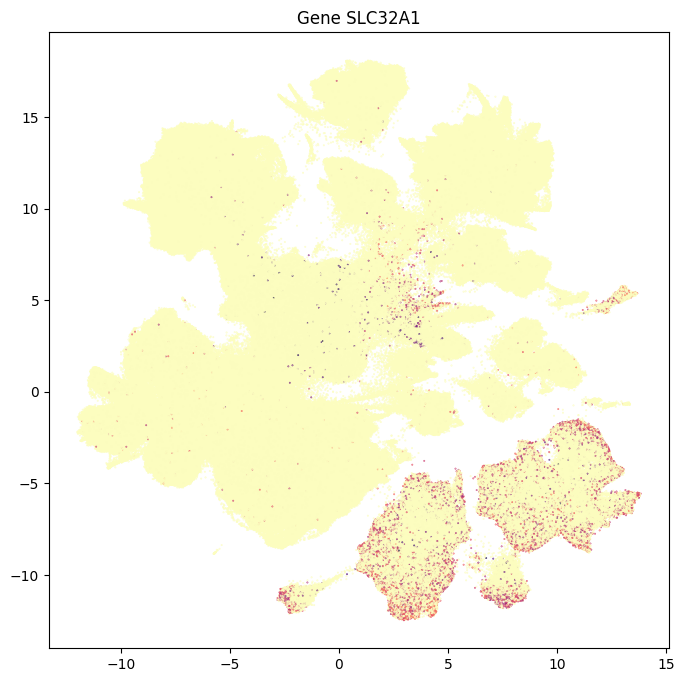

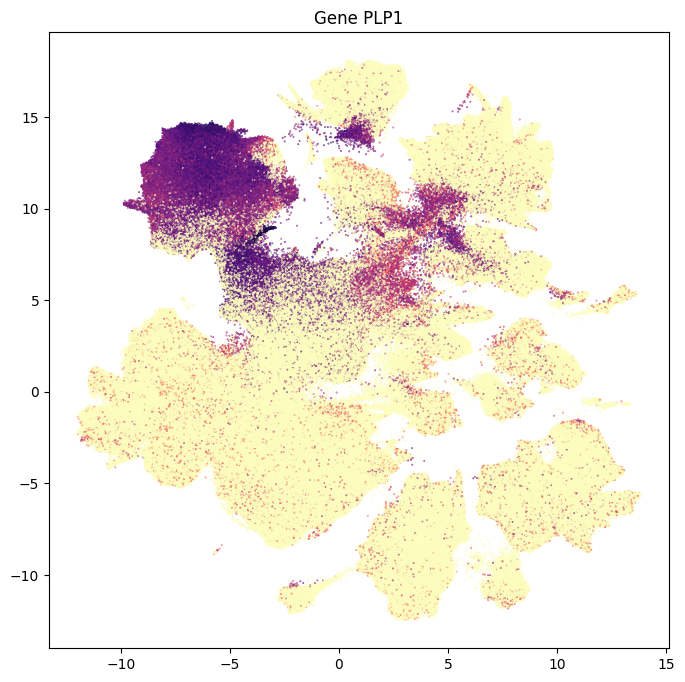

In [10]:
for gene_name in example_cells_with_genes.columns:
    fig, ax = plot_umap(
        cell_metadata['x'],
        cell_metadata['y'],
        val=cell_metadata[gene_name],
        cmap=plt.cm.magma_r
    )
    res = ax.set_title(f"Gene {gene_name}")
    plt.show()

In related notebooks, you can learn about the [ASAP-PMDBS](https://alleninstitute.github.io/abc_atlas_access/notebooks/asap_pmdbs_data_and_metadata.html) data as well as how we can use the output of MapMyCells to map these cells and their gene expression into the [Siletti, Whole Human Brain (WHB) taxonomy](https://alleninstitute.github.io/abc_atlas_access/notebooks/asap_pmdbs_siletti_taxonomy.html) and the [SEA-AD taxonomy](https://alleninstitute.github.io/abc_atlas_access/notebooks/asap_pmdbs_seaad_taxonomy.html).